# Training the mask classification model

We train a model with a MobileNetV1 base with ImageNet pre-trained weights to distinguish between masked and non-masked faces.  
The MobileNetV1 base is followed by a fully connected layer and a layer with sigmoid activiation for classification.  
Only the final 4 layers of the model are finetuned, other weights are frozen.

### Training

Only unmasked and artificially masked data based on VGGFace2 (see prep_data.ipynb) are used to train the model.  

### Validation
We work with two separate validation set: 
  1. One containing masked and artificially masked data based on VGGFace2
  2. One containing unmasked and real masked data from our own collected dataset.  
  
This helps us to distinguish between performance on artificial and real data.  

In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.applications.mobilenet import MobileNet
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.applications.mobilenet import preprocess_input

import keras 

from sklearn import metrics 
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import itertools
import random
from collections import namedtuple
import os

Using TensorFlow backend.


## Setup

In [2]:
target_size = (112,112)
batch_size = 32
lr = 0.01
n_epochs = 2 

root_dir = os.path.dirname(os.path.abspath(os.curdir))
data_dir = Path(root_dir) / 'data'

model_dir = data_dir / 'classifier_model_weights'
model_dir.mkdir(exist_ok=True)

performance_plots_dir = Path('img')
performance_plots_dir.mkdir(exist_ok=True)

## Create train/validation/test generators

The unmasked and artificially masked images from VGGFace2 are divided into a training and validation set. 

In [3]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
train_generator = train_datagen.flow_from_directory(str(data_dir / 'train'),
                                                    target_size=target_size,
                                                    batch_size=batch_size,
                                                    class_mode='binary',
                                                    classes=['not_masked', 'masked'],
                                                    shuffle=True)

Found 3948 images belonging to 2 classes.


In [4]:
val_datagen_artificial = ImageDataGenerator(preprocessing_function=preprocess_input)
val_generator_artificial = val_datagen_artificial.flow_from_directory(str(data_dir / 'validation' / 'artificial'),
                                                    target_size=target_size,
                                                    batch_size=batch_size,
                                                    class_mode='binary',
                                                    classes=['not_masked', 'masked'],
                                                    shuffle=False)

Found 986 images belonging to 2 classes.


In [5]:
val_datagen_real = ImageDataGenerator(preprocessing_function=preprocess_input)
val_generator_real = val_datagen_real.flow_from_directory(str(data_dir / 'validation' / 'real'),
                                                    target_size=target_size,
                                                    batch_size=batch_size,
                                                    class_mode='binary',
                                                    classes=['not_masked', 'masked'],
                                                    shuffle=False)

Found 262 images belonging to 2 classes.


## Defining the model

MobileNet base with 1 fully connected layers on top and one final layer with sigmoid activation that outputs predictions.  
Only the last layers are trained, others are frozen.

In [6]:
base_model = MobileNet(weights='imagenet',include_top=False, input_shape=(target_size[0],target_size[1],3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x) 
preds = Dense(1,activation='sigmoid')(x)

model = Model(inputs=base_model.input,outputs=preds)

for layer in model.layers[:-4]:
    layer.trainable = False

/home/toon/mask_env_37/lib/python3.7/site-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [7]:
class SubsetAccuracy(keras.callbacks.Callback):
    """
    We want to monitor accuracy in the validation set separately for real and artificial face masks.
    This callback will print this to the output, and store the values for each epoch.
    
    It also stores the best model (according to validation accuracy on the masked faces) to disk.
    """
    
    def __init__(self, real_val_gen=None):
        self.real_val_gen = real_val_gen
        self.cur_best_acc = 0
        
    def on_epoch_end(self, batch, logs={}):
        pred = self.model.predict(self.real_val_gen)
        bin_pred = [x > 0.5 for x in pred]
        real_acc = metrics.accuracy_score(self.real_val_gen.classes, bin_pred)
        
        print(f"Accuracy on the real validation set: {real_acc:.2f}")
        
        if real_acc > self.cur_best_acc:
            self.model.save(model_dir / 'best.h5')
            self.cur_best_acc = real_acc
          
subset_acc = SubsetAccuracy(val_generator_real)

## Compiling and training

In [8]:
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt,loss='binary_crossentropy',metrics=['accuracy'])
step_size_train = train_generator.n//train_generator.batch_size
step_size_val = val_generator_artificial.n//val_generator_artificial.batch_size

In [9]:
model.fit_generator(generator=train_generator, steps_per_epoch=step_size_train, epochs=n_epochs, validation_data=val_generator_artificial, validation_steps=step_size_val, callbacks=[subset_acc])

Epoch 1/2
123/123 [==============================] - 27s 217ms/step - loss: 0.1693 - accuracy: 0.9461 - val_loss: 0.0022 - val_accuracy: 0.9771
Accuracy on the real validation set: 0.90
Epoch 2/2
123/123 [==============================] - 26s 211ms/step - loss: 0.0515 - accuracy: 0.9819 - val_loss: 1.3112e-07 - val_accuracy: 0.9465
Accuracy on the real validation set: 0.82


## Evaluation on real validation data

In [10]:
best_model = keras.models.load_model(model_dir / 'best.h5')

In [11]:
val_pred = best_model.predict_generator(val_generator_real)

## Helper functions

In [12]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    From: https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def print_stats(true_labels, pred, classification_threshold=0.5):
    """
    Print some performance statistics.
    """
    pred_bin = [x > classification_threshold for x in pred]
    acc = metrics.accuracy_score(true_labels, pred_bin)
    print(f"Accuracy = {acc:.3f}")

    cm = metrics.confusion_matrix(true_labels, pred_bin)
    plt.figure()
    plot_confusion_matrix(cm, ['not masked', 'masked'])
    plt.savefig(performance_plots_dir / 'confusion.png', bbox_inches='tight', pad_inches=0)
    
    fpr, tpr, thr = metrics.roc_curve(true_labels, pred)
    auc = metrics.auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', size=15)
    plt.ylabel('True Positive Rate', size=15)
    plt.title(f'AUC = {auc:.3f}', size=15)
    plt.savefig(performance_plots_dir / 'roc.png', bbox_inches='tight', pad_inches=0)

In [13]:
val_pred_bin = [x[0] > 0.5 for x in val_pred]

acc = metrics.accuracy_score(val_generator_real.classes, val_pred_bin)
print(f"Accuracy = {acc:.3f}")

Accuracy = 0.897


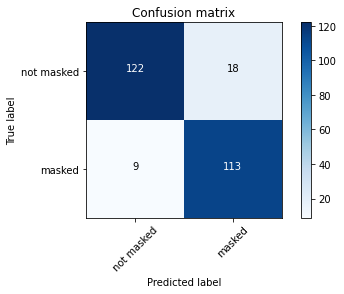

In [14]:
cm = metrics.confusion_matrix(val_generator_real.classes, val_pred_bin)
plt.figure()
plot_confusion_matrix(cm, ['not masked', 'masked'])
plt.savefig(performance_plots_dir / 'confusion.png', bbox_inches='tight', pad_inches=0)

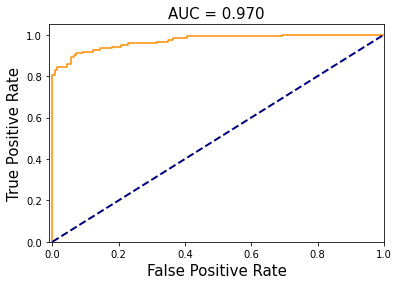

In [15]:
fpr, tpr, thr = metrics.roc_curve(val_generator_real.classes, val_pred)
auc = metrics.auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', size=15)
plt.ylabel('True Positive Rate', size=15)
plt.title(f'AUC = {auc:.3f}', size=15)
plt.savefig(performance_plots_dir / 'roc.png', bbox_inches='tight', pad_inches=0)

In [16]:
## TODO: add code to plot mistakes